# Preparação do ambiente

## Bibliotecas

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import unidecode
import warnings 

from joblib import dump, load

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from tabulate import tabulate
from unicodedata import normalize
from wordcloud import WordCloud

In [41]:
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore')

## Constantes e funções auxiliares

In [80]:
FILE_ITEMS = '../datasets/label_issues/20240423/results/items.parquet'
FILE_MODEL = '../models/clf_marketplaces.joblib'
FILE_EXP2_PERF = '../datasets/label_issues/20240423/results/exp2_perf_files.npz'
FILE_SUPERVISAO_MERCADO = '../datasets/supervisao_mercado/supervisao_mercado.xlsx'

In [43]:
def tokenizer(doc):
    doc = doc.lower()
    doc = unidecode.unidecode(doc)
    
    # uniformizar termos
    patterns = [('wi\s?.?fi', 'wifi'), 
                ('2,4', '2.4'), 
                ('5,8', '5.8')]
    for pattern, repl in patterns:
        doc = re.sub(pattern, repl, doc)
    
    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(punctuation))
    
    # stopwords específicas do domínio
    stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver', 'unidades', 'fio', 'universal'])
    
    # cores mais comumns
    stop_words.extend(['preto', 'cinza', 'branco', 'rosa', 'vermelho', 'laranja', 'amarelo', 'verde', 'azul', 'roxo', 'marrom'])
    
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", que pode ser relevante para o domínio
    # stop_words.remove('sem') 
    
    tokens = [token for token in word_tokenize(doc) if token not in stop_words]
    return tokens

# def doc_cleaner(doc):
#     tokens = tokenizer(doc)
#     return ' '.join(tokens) 

In [44]:
def clean_text(doc, return_tokens=False, nltk_tokenizer=True):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # testes nessa rodada confirmaram que não faz difença
    # stop_words.remove('sem')

    doc = doc.lower()

    # normalize docs
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')
    # normalize stopwords
    stop_words = [normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII') for word in stop_words]
    
    # word regularization
    # wi-fi
    pattern = 'wi.fi'
    doc = re.sub(pattern, 'wifi', doc)
    
    # 2.4g and variations
    pattern = '2[.,]4(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '2_4ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 2.4g becomes 4g, remove punctuation early
    
    # 5.8g and variations
    pattern = '5[.,]8(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '5_8ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 5.8g becomes 8g, remove punctuation early

    if nltk_tokenizer:
        # nltk tokenizer
        tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    else:
        # CountVectorizer token pattern
        pattern = r'\b\w\w+\b'
        tokens = [token for token in re.findall(pattern,doc) if token not in stop_words]

    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

In [45]:
def plot_docs_matrix(docs_matrix, true_targets=None, predicted_targets=None, title=None):
    pca = TruncatedSVD(n_components=2)
    pca_matrix = pca.fit_transform(docs_matrix)
    scatter_x = pca_matrix[:, 0] # first principle component
    scatter_y = pca_matrix[:, 1] # second principle component
    
    if predicted_targets is None:
        fig,ax = plt.subplots(figsize=(6,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                ax.scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    ax.set_title('Anúncios por grupo\n(Real)')   
                else:
                    ax.set_title(title)
        else:
            ax.scatter(scatter_x, scatter_y, s=5)
            if title is None:
                ax.set_title('Anúncios')
            else:
                ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        
    else:
        fig,axs = plt.subplots(1,2,figsize=(12,5))
        if true_targets is not None:
            for group in np.unique(true_targets):
                ix = np.where(true_targets == group)
                axs[0].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
                if title is None:
                    axs[0].set_title('Anúncios por grupo\n(Real)')   
                else:
                    axs[0].set_title(title)
        else:
            axs[0].scatter(scatter_x, scatter_y, s=5)
            if title is None:
                axs[0].set_title('Anúncios')
            else:
                axs[0].set_title(title)
        
        for group in np.unique(predicted_targets):
            ix = np.where(predicted_targets == group)
            axs[1].scatter(scatter_x[ix], scatter_y[ix], label=group, s=5)
            axs[1].set_title('Anúncios por grupo\n(K-Means)')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])
        
    plt.show()

In [46]:
def plot_wordcloud(wc_docs,max_words=50,ax=None,title='Principais palavras'):

    if hasattr(wc_docs, '__iter__'):
        wc_docs = ' '.join(wc_docs)
   
    wc = WordCloud(max_words=max_words,height=300).generate(wc_docs)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5,5))
        show_plt = True
    else: 
        show_plt = False
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

    if show_plt:
        plt.show()

# Carga e prepação dos dados

In [47]:
df_items = pd.read_parquet(FILE_ITEMS)

map_groups = {(0,0):0, (1,0):1, (1,1):2}
df_items['grupo'] = df_items.apply(lambda row: (row['passivel_homologacao'],row['transmissor_rf']),axis=1).map(map_groups).fillna(3).astype(int)

df_items

,id,nome,desc,titulo_bem_elaborado,titulo_identifica_produto,desc_bem_elaborada,desc_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto,grupo
0,125728,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,STREAMING BOX S - 2GB RAM | 32GB ARMAZENAMENTO...,1,1,1,1,1,1,TV Box/TV Stick,2
1,125729,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,Fotografia profissional no seu bolsoDescubra i...,1,1,1,1,1,1,Smartphones,2
2,125730,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,Os produtos da Dell destacam-se por oferecer s...,1,1,1,1,1,1,Computador ou notebook,2
3,125731,"Mini rede sem fio, placa de rede sem fio USB 3...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
4,125732,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...","Fone Bluetooth Tws, Kaidi Kd-771, Bluetooth 5....",1,1,1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
...,...,...,...,...,...,...,...,...,...,...,...
18831,125715,CAIXA ACUSTICA PCX6500,,0,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
18832,125716,Conector de cauda de celular 10 pcs carregando...,"[De alta qualidade] 100% nova fábrica, segura...",1,1,1,1,0,0,Outro tipo/categoria (não listada acima),0
18833,125717,Avantree Medley Clear - Fones de ouvido sem fi...,,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2
18834,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",,1,1,2,2,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz),2


# Análise

## Análise exploratória

In [48]:
df_tipo_produto = df_items[['tipo_produto','id']].groupby('tipo_produto').count()
df_tipo_produto = df_tipo_produto.sort_values(by='id',ascending=False)
df_tipo_produto.columns = ['Quantidade']
df_tipo_produto.index.name = 'Tipo de produto'
df_tipo_produto

,Quantidade
Tipo de produto,
Outro tipo/categoria (não listada acima),8242
Transceptor de radiação restrita (2.4GHz/5.8GHz),3529
Não é possível afirmar,1503
Carregador para celular (inclusive powerbank),1359
Smartphones,1177
Drone,758
Transceptor de radiofrequência (VHF/UHF),464
Roteador/repetidor/reforçador WiFi (2.4GHz/5.8GHz),458
Bateria de lítio para celular,439


In [49]:
map_titulo = {0: 'Não', 1: 'Sim'}
df_titulo = df_items.pivot_table(index='titulo_bem_elaborado',columns='titulo_identifica_produto',values='id',aggfunc='count')
df_titulo.columns = df_titulo.columns.map(map_titulo)
df_titulo.columns.name = 'Título identifica o produto?'
df_titulo.index = df_titulo.index.map(map_titulo)
df_titulo.index.name = 'Título bem elaborado?'
df_titulo['Total'] = df_titulo.sum(axis=1)
df_titulo.loc['Total'] = df_titulo.sum(axis=0)

df = df_titulo.style.format(precision=3, thousands=".", decimal=",")
display(df)

Título identifica o produto?,Não,Sim,Total
Título bem elaborado?,,,
Não,1.662,5.064,6.726
Sim,304,11.806,12.110
Total,1.966,16.870,18.836


In [50]:
map_desc = {0: 'Não', 1: 'Sim', 2: 'Anúncio não possui descrição'}
df_desc = df_items.pivot_table(index='desc_bem_elaborada',columns='desc_identifica_produto',values='id',aggfunc='count')
df_desc.columns = df_desc.columns.map(map_desc)
df_desc.columns.name = 'Descrição identifica o produto?'
df_desc.index = df_desc.index.map(map_desc)
df_desc.index.name = 'Descrição bem elaborada?'
df_desc['Total'] = df_desc.sum(axis=1)
df_desc.loc['Total'] = df_desc.sum(axis=0)

df = df_desc.style.format(precision=3, thousands=".", decimal=",")
display(df)

Descrição identifica o produto?,Não,Sim,Anúncio não possui descrição,Total
Descrição bem elaborada?,,,,
Não,915,1.498,6,2.419
Sim,228,6.972,8,7.208
Anúncio não possui descrição,6,21,9.182,9.209
Total,1.149,8.491,9.196,18.836


In [51]:
map_passivel = {0: 'Não', 1: 'Sim', 2: 'Não é possível afirmar'}
df_passivel = df_items.pivot_table(index='passivel_homologacao',columns='transmissor_rf',values='id',aggfunc='count')
df_passivel = df_passivel.fillna(0).astype(int)
df_passivel.columns = df_passivel.columns.map(map_passivel)
df_passivel.columns.name = 'Produto transmissor de RF?'
df_passivel.index = df_passivel.index.map(map_passivel)
df_passivel.index.name = 'Produto passível de homologação?'
df_passivel['Total'] = df_passivel.sum(axis=1)
df_passivel.loc['Total'] = df_passivel.sum(axis=0)

df = df_passivel.style.format(precision=3, thousands=".", decimal=",")
display(df)

Produto transmissor de RF?,Não,Sim,Não é possível afirmar,Total
Produto passível de homologação?,,,,
Não,7.471,0,2,7.473
Sim,1.978,7.888,53,9.919
Não é possível afirmar,68,2,1.374,1.444
Total,9.517,7.890,1.429,18.836


In [52]:
df_passivel = df_items[(df_items['passivel_homologacao']<2)&(df_items['transmissor_rf']<2)].pivot_table(index='passivel_homologacao',columns='transmissor_rf',values='id',aggfunc='count')
df_passivel = df_passivel.fillna(0).astype(int)
df_passivel.columns = df_passivel.columns.map(map_passivel)
df_passivel.columns.name = 'Produto transmissor de RF?'
df_passivel.index = df_passivel.index.map(map_passivel)
df_passivel.index.name = 'Produto passível de homologação?'
df_passivel['Total'] = df_passivel.sum(axis=1)
df_passivel.loc['Total'] = df_passivel.sum(axis=0)

df = df_passivel.style.format(precision=3, thousands=".", decimal=",")
display(df)

Produto transmissor de RF?,Não,Sim,Total
Produto passível de homologação?,,,
Não,7.471,0,7.471
Sim,1.978,7.888,9.866
Total,9.449,7.888,17.337


## Espaço vetorial

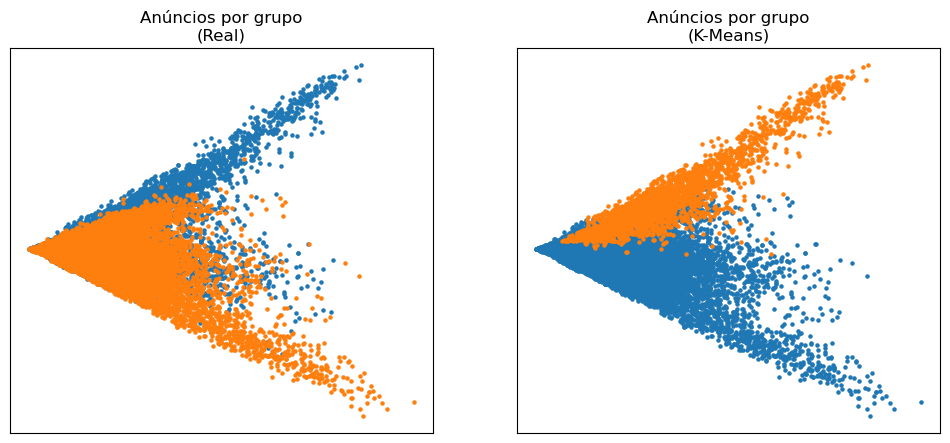

In [53]:
columns_to_keep = ['nome','passivel_homologacao']
df_docs = df_items[df_items['passivel_homologacao']<2][columns_to_keep]

docs_passivel = df_docs['nome'].values
targets_passivel = df_docs['passivel_homologacao'].values

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix_passivel = vectorizer.fit_transform(docs_passivel)

kmeans_passivel = KMeans(n_clusters=2, max_iter=500, n_init=3).fit(docs_matrix_passivel)
predicted_targets_passivel = kmeans_passivel.labels_

plot_docs_matrix(docs_matrix_passivel,true_targets=targets_passivel,predicted_targets=predicted_targets_passivel)

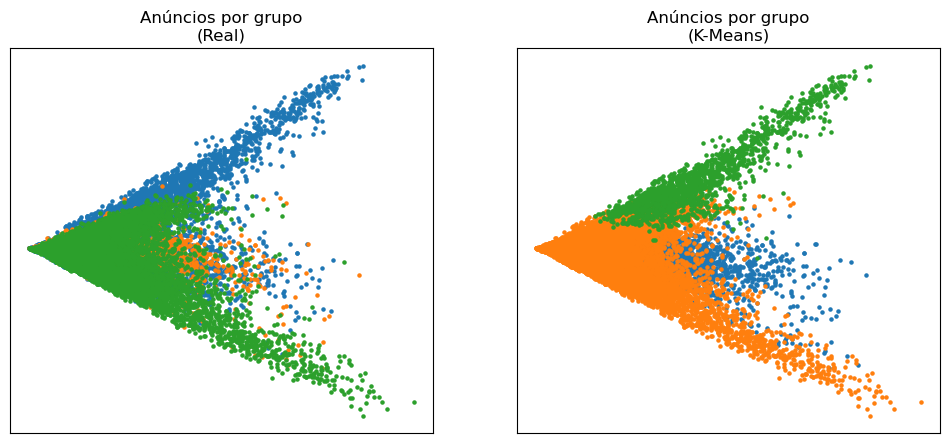

In [54]:
columns_to_keep = ['nome','grupo']
df_docs_grupo = df_items[df_items['grupo']<3][columns_to_keep]

docs_grupo = df_docs_grupo['nome'].values
targets_grupo = df_docs_grupo['grupo'].values

vectorizer = TfidfVectorizer(tokenizer=tokenizer)
docs_matrix_grupo = vectorizer.fit_transform(docs_grupo)

kmeans_grupo = KMeans(n_clusters=3, max_iter=500, n_init=3).fit(docs_matrix_grupo)
predicted_targets_grupo = kmeans_grupo.labels_

plot_docs_matrix(docs_matrix_grupo,true_targets=targets_grupo,predicted_targets=predicted_targets_grupo)

## Principais palavras

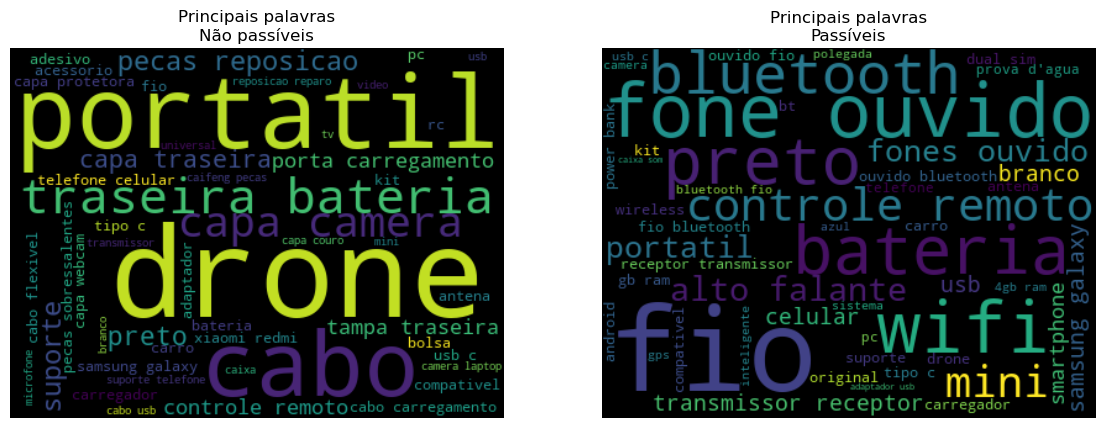

In [55]:
map_passivel = {
    0: 'Não passíveis', 
    1: 'Passíveis'}

fig, axs = plt.subplots(1,2,figsize=(14,5))

targets = [0,1]
for target in targets:
    docs = df_items[df_items['passivel_homologacao']==target]['nome']
    docs = [clean_text(doc) for doc in docs]
    title = f'Principais palavras\n{map_passivel[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

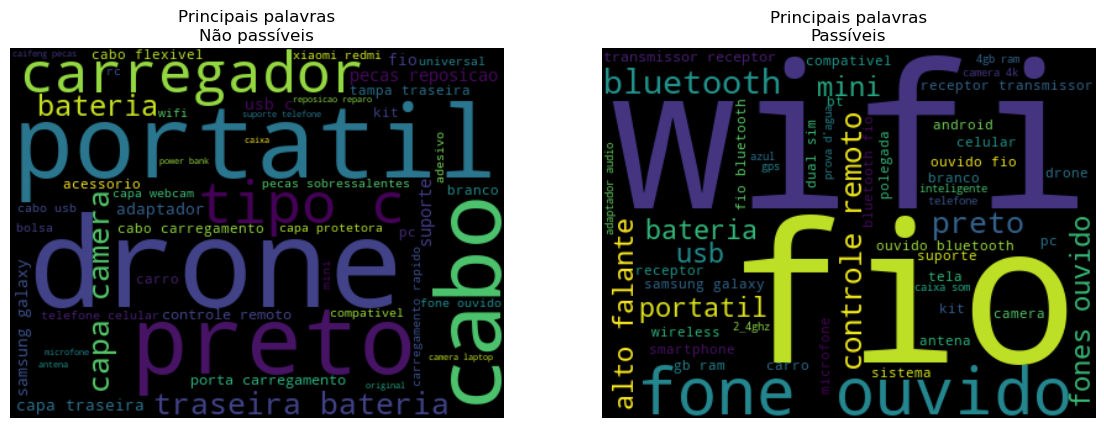

In [56]:
map_transmissor_rf = {
    0: 'Não transmissor', 
    1: 'Transmissor de RF'}

fig, axs = plt.subplots(1,2,figsize=(14,5))

targets = [0,1]
for target in targets:
    docs = df_items[df_items['transmissor_rf']==target]['nome']
    docs = [clean_text(doc) for doc in docs]
    title = f'Principais palavras\n{map_passivel[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

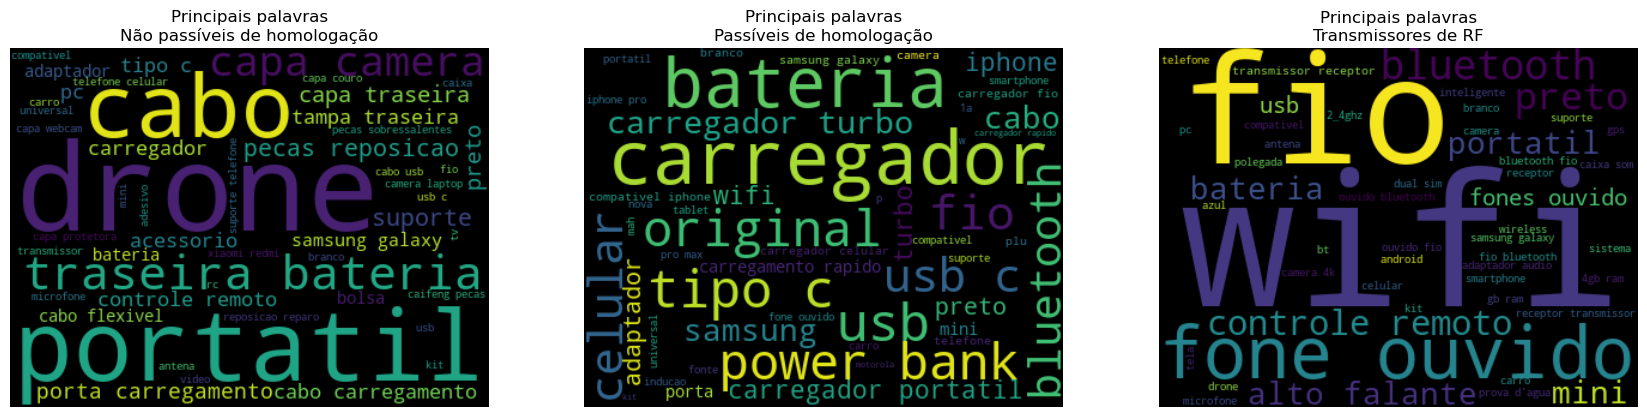

In [57]:
map_group = {
    0: 'Não passíveis de homologação', 
    1: 'Passíveis de homologação', 
    2: 'Transmissores de RF'}

fig, axs = plt.subplots(1,3,figsize=(21,5))

targets = [0,1,2]
for target in targets:
    docs = df_items[df_items['grupo']==target]['nome']
    docs = [clean_text(doc) for doc in docs]
    title = f'Principais palavras\n{map_group[target]}'
    plot_wordcloud(docs,ax=axs[target],title=title)

## Classificador SGD

### Treinamento com dados rotulados

Accuracy of SGD classifier on training set: 0.996
Accuracy of SGD classifier on test set: 0.916
AUC of SGD classifier on training set: 1.000
AUC of SGD classifier on test set: 0.966

               precision    recall  f1-score   support

Não passíveis       0.93      0.87      0.90      1877
    Passíveis       0.91      0.95      0.93      2471

     accuracy                           0.92      4348
    macro avg       0.92      0.91      0.91      4348
 weighted avg       0.92      0.92      0.92      4348

CPU times: total: 2.25 s
Wall time: 2.94 s


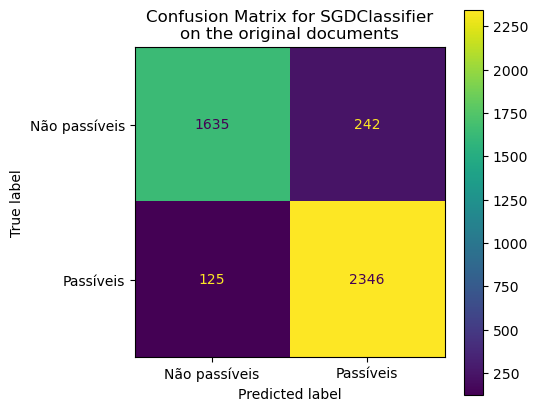

In [78]:
%%time
# stop words
stop_words = stopwords.words('portuguese')
stop_words.extend(stopwords.words('english'))

# vetorizar as palavras por contagem
vectorizer = CountVectorizer(ngram_range=(1,2),stop_words=stop_words)

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps=[('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

# 
docs = df_items[df_items['passivel_homologacao']<2]['nome']
labels = df_items[df_items['passivel_homologacao']<2]['passivel_homologacao']
target_names = list(map_passivel.values())

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=123)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)
    
# persist model
dump(pipe, FILE_MODEL) 

predicted = pipe.predict(X_test)
y_scores = pipe.decision_function(X_test)
auc_sgd = roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])

precisons,recalls,precisions_recalls_thresholds = precision_recall_curve(y_test,y_scores)
fpr,tpr,auc_thresholds = roc_curve(y_test,y_scores)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(pipe.score(X_train, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(pipe.score(X_test, y_test)))
print('AUC of SGD classifier on training set: {:.3f}'
     .format(roc_auc_score(y_train,pipe.predict_proba(X_train)[:,1])))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(f"Confusion Matrix for {pipe['clf'].__class__.__name__}\non the original documents")

In [63]:
# # experiment 2 performance files
# exp2_perf_files = np.load(FILE_EXP2_PERF)
# exp2_precisons = exp2_perf_files['precisons']
# exp2_recalls = exp2_perf_files['recalls']
# exp2_precisions_recalls_thresholds = exp2_perf_files['precisions_recalls_thresholds']
# exp2_fpr = exp2_perf_files['fpr']
# exp2_tpr = exp2_perf_files['tpr']
# exp2_auc_thresholds = exp2_perf_files['auc_thresholds']
# exp2_auc_sgd = exp2_perf_files['auc_sgd']

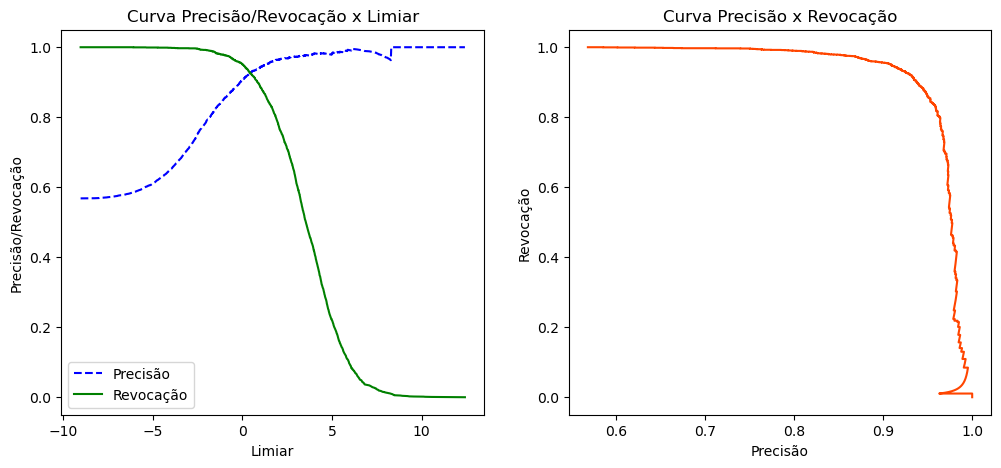

In [22]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(precisions_recalls_thresholds, precisons[:-1], 'b--', label='Precisão')
axs[0].plot(precisions_recalls_thresholds, recalls[:-1], 'g-', label='Revocação')

axs[0].set_xlabel('Limiar')
axs[0].set_ylabel('Precisão/Revocação')
axs[0].set_title('Curva Precisão/Revocação x Limiar')
axs[0].legend()

axs[1].plot(precisons,recalls,'orangered')
axs[1].set_title('Curva Precisão x Revocação')
axs[1].set_xlabel('Precisão')
axs[1].set_ylabel('Revocação')

plt.show()

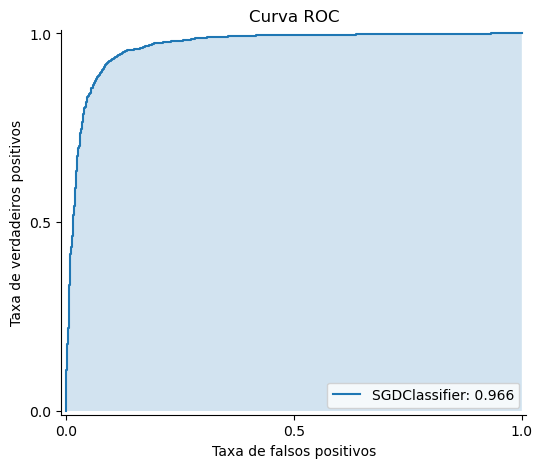

In [23]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.plot(fpr,tpr,label=f'SGDClassifier: {auc_sgd:.3f}')

ax.fill_between(fpr,tpr,alpha=0.2)
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)

ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

# remove the frame of the chart
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Curva ROC')
ax.set_xlabel('Taxa de falsos positivos')
ax.set_ylabel('Taxa de verdadeiros positivos')
ax.legend(loc='lower right')

plt.show()

### Validação com dados reais (Supervisão de Mercado)

Accuracy of SGD classifier on validation set: 0.903
AUC of SGD classifier on validation set: 0.963

               precision    recall  f1-score   support

Não passíveis       0.89      0.57      0.69       163
    Passíveis       0.91      0.98      0.94       683

     accuracy                           0.90       846
    macro avg       0.90      0.78      0.82       846
 weighted avg       0.90      0.90      0.89       846



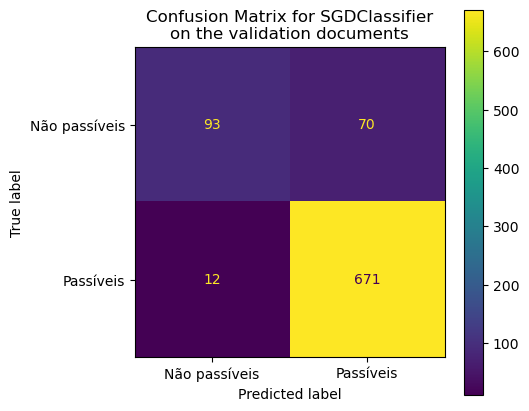

In [133]:
dict_df_mercado = pd.read_excel(
    FILE_SUPERVISAO_MERCADO,
    sheet_name=None,
    usecols=[2,8,10],
    names=['texto_busca', 'descricao', 'passivel_homologacao'],
    true_values=['Sim', 'sim'],
    false_values=['Não','não'],
    na_values=['-'])

df_mercado = pd.concat(dict_df_mercado.values())
df_mercado = df_mercado.dropna()
df_mercado['passivel_homologacao'] = df_mercado['passivel_homologacao'].astype(int)

X_validation = df_mercado.descricao.values
y_validation = df_mercado.passivel_homologacao.values

predicted_validation = pipe.predict(X_validation)
y_scores_validation = pipe.decision_function(X_validation)
auc_sgd = roc_auc_score(y_validation,pipe.predict_proba(X_validation)[:,1])

df_mercado['predicao'] = predicted_validation
df_mercado['probabilidade'] = pipe.predict_proba(X_validation)[:,1]

precisons,recalls,precisions_recalls_thresholds = precision_recall_curve(y_validation,y_scores_validation)
fpr,tpr,auc_thresholds = roc_curve(y_validation,y_scores_validation)

print('Accuracy of SGD classifier on validation set: {:.3f}'
     .format(pipe.score(X_validation, y_validation)))
print('AUC of SGD classifier on validation set: {:.3f}'
     .format(roc_auc_score(y_validation,pipe.predict_proba(X_validation)[:,1])))

print()
print(classification_report(y_validation, predicted_validation, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_validation, predicted_validation, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(f"Confusion Matrix for {pipe['clf'].__class__.__name__}\non the validation documents")

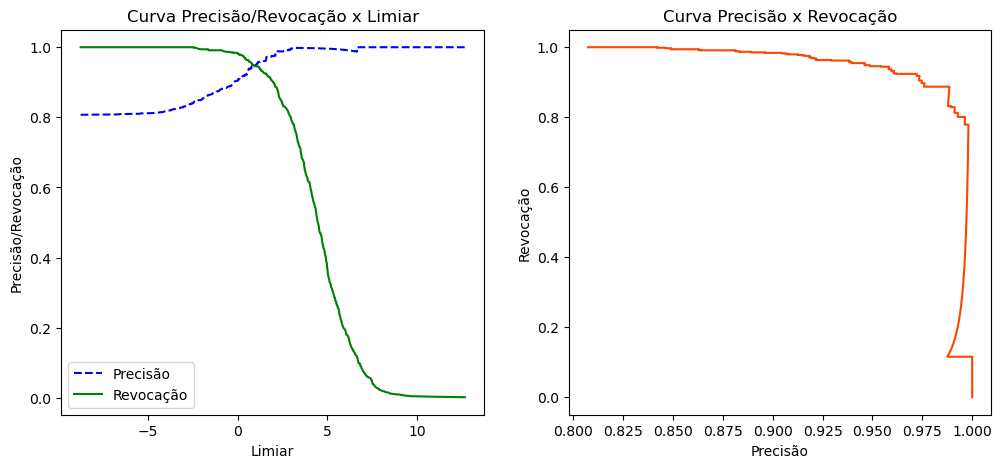

In [128]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(precisions_recalls_thresholds, precisons[:-1], 'b--', label='Precisão')
axs[0].plot(precisions_recalls_thresholds, recalls[:-1], 'g-', label='Revocação')

axs[0].set_xlabel('Limiar')
axs[0].set_ylabel('Precisão/Revocação')
axs[0].set_title('Curva Precisão/Revocação x Limiar')
axs[0].legend()

axs[1].plot(precisons,recalls,'orangered')
axs[1].set_title('Curva Precisão x Revocação')
axs[1].set_xlabel('Precisão')
axs[1].set_ylabel('Revocação')

plt.show()

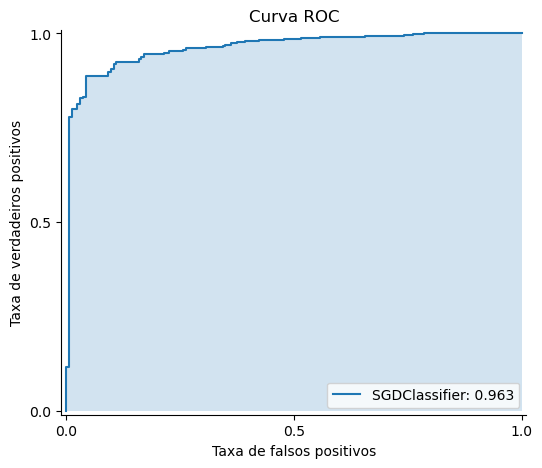

In [129]:
fig,ax = plt.subplots(1,1,figsize=(6,5))

ax.plot(fpr,tpr,label=f'SGDClassifier: {auc_sgd:.3f}')

ax.fill_between(fpr,tpr,alpha=0.2)
ax.set_xlim(-0.01,1.01)
ax.set_ylim(-0.01,1.01)

ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])

# remove the frame of the chart
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Curva ROC')
ax.set_xlabel('Taxa de falsos positivos')
ax.set_ylabel('Taxa de verdadeiros positivos')
ax.legend(loc='lower right')

plt.show()

In [137]:
df_mercado[(df_mercado['passivel_homologacao']==1)&(df_mercado['predicao']==0)]

,texto_busca,descricao,passivel_homologacao,predicao,probabilidade
129,TV Box,Tv Box + Adaptador Hdmi-rca Kit Para Tv Mais A...,1,0,0.305859
185,Flipper Zero,"Leitor E Gravador Rfid, Leitor De Cartão De Id...",1,0,0.100064
187,Flipper Zero,Leitor De Cartão Gravador Duplicador De Cartão De,1,0,0.160850
189,Flipper Zero,Leitor Portátil De Cartão De Identificação Rfid,1,0,0.078682
43,Carregador para Smartphone,"Motorola, Carregador Rapido 10w, 100-240V, cab...",1,0,0.495513
59,Carregador para Smartphone,Display Digital Carregador de 6 Portas Multipo...,1,0,0.387569
111,TV Box,"Receptor Digital de TV via satélite, Full HD, ...",1,0,0.439115
114,TV Box,"Conversor de TV digital, ATSC Cabal Box – ZJBO...",1,0,0.087940
115,TV Box,"Receptor Digital de TV via satélite, com Parab...",1,0,0.325726
126,TV Box,KOSDFOGE Interface Multimídia HD para Converso...,1,0,0.093854
